In [42]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

import aesara
import aesara.tensor as at

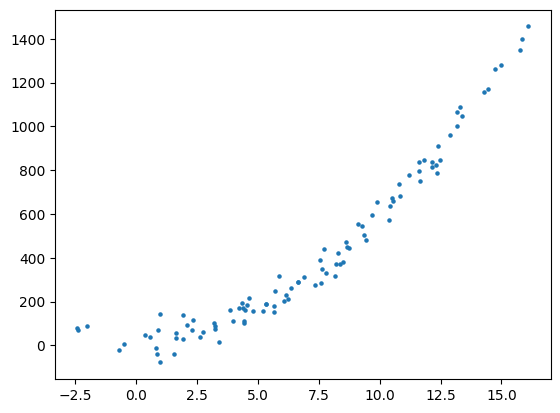

In [43]:
# 模拟数据
X = np.random.randn(100) * 5 +7
error = np.random.randn(100) * 50
Y_obs = 5 * X ** 2 + 10 * X + error

plt.scatter(X, Y_obs, s=5)

In [44]:
def check(X, trace, name):
    X_test = np.linspace(np.floor(X.min()), np.ceil(X.max()), 100)

    # 真值
    Y_true = 5 * X_test ** 2 + 10 * X_test

    # 计算后验平均值
    a_posterior_mean = trace.posterior["a"].mean().values
    b_posterior_mean = trace.posterior["b"].mean().values
    c_posterior_mean = trace.posterior["c"].mean().values
    Y_fit = a_posterior_mean * X_test ** 2 + b_posterior_mean * X_test + c_posterior_mean

    # 计算后验标准差
    a_posterior_std = trace.posterior["a"].std().values
    b_posterior_std = trace.posterior["b"].std().values
    c_posterior_std = trace.posterior["c"].std().values
    Y_errorpred = a_posterior_std * X_test ** 2 + b_posterior_std * X_test + c_posterior_std

    edge1 = Y_fit + Y_errorpred
    edge2 = Y_fit - Y_errorpred

    MSE = np.mean((Y_fit - Y_true) ** 2)

    # 绘制填充区间
    # 绘制数据点
    plt.scatter(X, Y_obs, s=5)

    # 绘制后验平均拟合线
    plt.plot(X_test, Y_fit, color='red', label='a={:.2f} b={:.2f} c={:.2f} MSE={:.2f}'.format(
            a_posterior_mean, b_posterior_mean, c_posterior_mean, MSE))

    plt.fill_between(X_test, edge2, edge1, color='blue', alpha=0.3)

    plt.title(name)

    # 显示图例
    plt.legend()

    # 显示图表
    plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


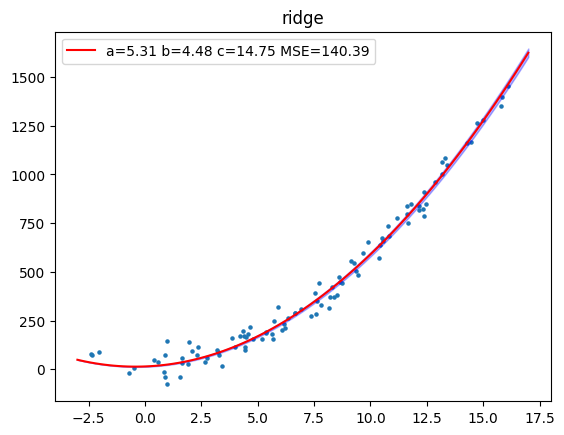

In [45]:
# Ridge regularization parameter (lambda for ridge penalty)
lambda_ridge = 0.1  # ridge regression 的 lambda, 正则化强度参数

with pm.Model() as model_ridge:
    # Priors for unknown model parameters with regularization
    # a,b,c with ridge penalty (small sigma means regularization)
    a = pm.Normal('a', mu=0, sigma=1/np.sqrt(2*lambda_ridge))
    b = pm.Normal('b', mu=0, sigma=1/np.sqrt(2*lambda_ridge))
    c = pm.Normal('c', mu=0, sigma=1/np.sqrt(2*lambda_ridge))

    # Expected value of outcome
    Y_pred = a * X ** 2 + b * X + c

    # Likelihood (sampling distribution) of observations
    Y = pm.Normal('Y', mu=Y_pred, sigma=10, observed=Y_obs)

    # Sampling
    trace_ridge = pm.sample(1000, tune=1000, return_inferencedata=True)

name1 = "ridge"
check(X, trace_ridge, name1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, a_ridge, b, b_ridge, c, c_ridge]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 92 seconds.


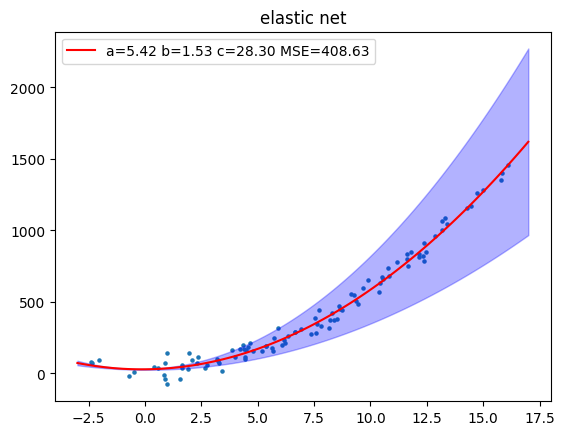

In [46]:
# Elastic Net regularization parameters
lambda_en = 0.12  # Ridge (L2) 正则化参数
alpha_en = 0.05  # Lasso (L1) 正则化参数

with pm.Model() as model_elastic_net:
    # Priors for unknown model parameters with elastic net regularization
    # a,b,c with both L1 and L2 penalties
    a = pm.Laplace('a', mu=0, b=1/(lambda_en * alpha_en)) + \
        pm.Normal('a_ridge', mu=0, sigma=1/np.sqrt(2*(lambda_en * (1 - alpha_en))))
    b = pm.Laplace('b', mu=0, b=1/(lambda_en * alpha_en)) + \
        pm.Normal('b_ridge', mu=0, sigma=1/np.sqrt(2*(lambda_en * (1 - alpha_en))))
    c = pm.Laplace('c', mu=0, b=1/(lambda_en * alpha_en)) + \
        pm.Normal('c_ridge', mu=0, sigma=1/np.sqrt(2*(lambda_en * (1 - alpha_en))))

    # Expected value of outcome
    Y_pred = a * X ** 2 + b * X + c

    # Likelihood (sampling distribution) of observations
    Y = pm.Normal('Y', mu=Y_pred, sigma=10, observed=Y_obs)

    # Sampling
    trace_en = pm.sample(1000, tune=1000, return_inferencedata=True)

name2 = "elastic net"
check(X, trace_en, name2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 97 seconds.


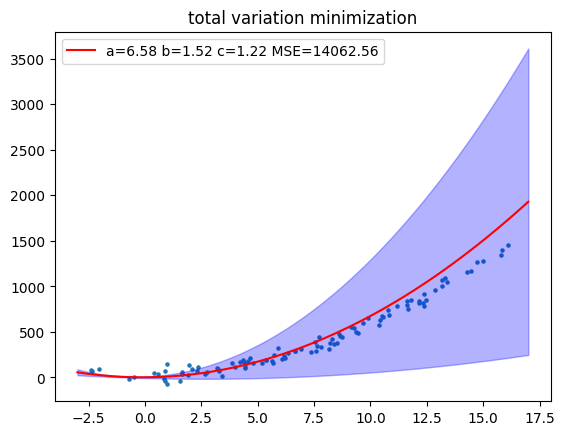

In [47]:
lambda_tv = 0.1

with pm.Model() as model_tv:
    a = pm.Normal('a', mu=0, sigma=10, shape=100)
    b = pm.Normal('b', mu=0, sigma=10, shape=100)
    c = pm.Normal('c', mu=0, sigma=10, shape=100)
    
    Y_pred = a * X ** 2 + b * X + c

    likelihood = pm.Normal('Y_obs', mu=Y_pred, sigma=10, observed=Y_obs)

    sum_dif_a = sum(abs(a[1:] - a[:-1]))
    sum_dif_b = sum(abs(b[1:] - b[:-1]))
    sum_dif_c = sum(abs(c[1:] - c[:-1]))

    
    pm.Potential(f'a_tv', pm.logp(pm.Laplace.dist(mu=0, b=1/lambda_tv), sum_dif_a))
    pm.Potential(f'b_tv', pm.logp(pm.Laplace.dist(mu=0, b=1/lambda_tv), sum_dif_b))
    pm.Potential(f'c_tv', pm.logp(pm.Laplace.dist(mu=0, b=1/lambda_tv), sum_dif_c))

    # 采样
    trace_tv = pm.sample(1000, tune=1000, return_inferencedata=True)

name3 = "total variation minimization"
check(X, trace_tv, name3)